In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
using PyCall
using DynamicalSystems

In [64]:
function Tuyls!(du, u, p, t)

    α, τ, A, B, nA = p
    x, y = u[1:nA], u[nA + 1:end]    
    dx, dy = du[1:nA], du[nA + 1:end]
    
    for i=1:nA
        du[i] = x[i] * α * τ * ((A * y)[i] - dot(x, A * y)) + x[i] * α * sum([x[j] * log(x[j]/x[i]) for j=1:nA])
        du[nA + i] = y[i] * α * τ * ((B * x)[i] - dot(y, B * x)) + y[i] * α * sum([y[j] * log(y[j]/y[i]) for j=1:nA])
    end
    
end

Tuyls! (generic function with 1 method)

In [ ]:
function TuylsThreePlayer!(du, u, p, t)
    α, τ, P, nA = p
    x, y, z = u[1:nA], u[nA + 1:nA*2], u[nA*2 + 1:end]
    
    dx, dy, dz = du[1:nA], du[nA + 1:nA*2], du[nA*2 + 1:end]
    
    for i=1:nA
        dx[i] = x[i] * α * τ * ((P[1] * y * z)[i] - dot(x, P[1] * y * z)) + x[i] * α * sum([x[j] * log(x[j]/x[i]) for j=1:nA])
        dy[i] = y[i] * α * τ * ((P[2] * x * z)[i] - dot(y, P[2] * x * z)) + y[i] * α * sum([y[j] * log(y[j]/y[i]) for j=1:nA])
        dz[i] = z[i] * α * τ * ((P[3] * x * y)[i] - dot(z, P[3] * x * y)) + z[i] * α * sum([z[j] * log(z[j]/z[i]) for j=1:nA])
    end
    
    du = [dx; dy; dz]
end

In [79]:
py"""
def generateGames(gamma, nSim, nAct):
    import numpy as np

    nElements = nAct ** 2  # number of payoff elements in the matrix

    cov = np.eye(2 * nElements)  # <a_ij^2> = <b_ji^2> = 1
    cov[:nElements, nElements:] = np.eye(nElements) * gamma  # <a_ij b_ji> = Gamma
    cov[nElements:, :nElements] = np.eye(nElements) * gamma

    rewardAs, rewardBs = np.eye(nAct), np.eye(nAct)

    for i in range(nSim):
        rewards = np.random.multivariate_normal(np.zeros(2 * nElements), cov=cov)

        rewardAs = np.dstack((rewardAs, rewards[0:nElements].reshape((nAct, nAct))))
        # rewardAs = np.dstack((rewardAs, np.array([[1, 5], [0, 3]])))
        rewardBs = np.dstack((rewardBs, rewards[nElements:].reshape((nAct, nAct)).T))
        # rewardBs = np.dstack((rewardBs, np.array([[1, 0], [5, 3]])))
    return [rewardAs[:, :, 1:], rewardBs[:, :, 1:]]
"""

generateGames(gamma, nSim, nAct) = py"generateGames"(gamma, nSim, nAct)

generateGames (generic function with 1 method)

In [151]:
nA = 20
α, τ = [5e-2, 5e-2]

initCond1 = rand(nA)
initCond1 /= sum(initCond1)
initCond2 = rand(nA)
initCond2 /= sum(initCond2)

u0 = [initCond1; initCond2]

initCond1 += 1e-5 * ones(nA)
initCond1 /= sum(initCond1)

initCond2 += 1e-5 * ones(nA)
initCond2 /= sum(initCond2)

u1 = [initCond1; initCond2]

tspan = (0.0, 15000.0)

A, B = generateGames(-1, 1, nA)

# A, B = [[1 5;0 3], [1 5; 0 3]]
# p = (α, τ, A, B, nA)

p = (α, τ, A[:, :, 1], B[:,:, 1], nA)
prob = ODEProblem(Tuyls!,u0,tspan, p)

tu = ContinuousDynamicalSystem(Tuyls!, u0, p)
λ = lyapunovs(tu, 15000, dt = 1)

40-element Array{Float64,1}:
  1.897231117150308e-5
 -6.713813040223894e-6
 -9.146225262169852e-6
 -1.293711901273549e-5
 -1.4704506500259767e-5
 -1.664118931639343e-5
 -1.5760841465666245e-5
 -1.4494120964733981e-5
 -1.6525535088838837e-5
 -1.6522904596445956e-5
 -1.8187890994691026e-5
 -1.8957988273285664e-5
 -1.7995174161368554e-5
  ⋮
 -2.1608490969895717e-5
 -2.1507184291601744e-5
 -2.1477901097872566e-5
 -2.186261589088371e-5
 -2.1509357439517905e-5
 -2.1154887189706267e-5
 -2.1915681015698718e-5
 -2.1763719745305176e-5
 -2.210270983279486e-5
 -2.112891719731242e-5
 -2.32538238487797e-5
 -2.2612977213250376e-5

In [149]:
sol = solve(prob)

-0.012257453667681032

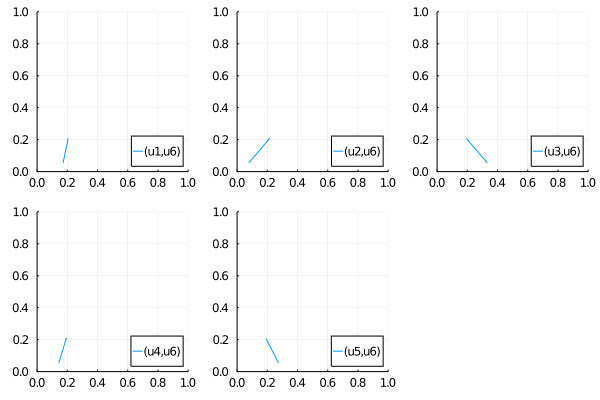

In [226]:
plots = [plot(sol, vars = (i, nA + i), xlims = (0, 1), ylims = (0, 1), legend=:bottomright) for i=1:nA]
plot(plots..., layout = nA)